In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                            | 0/50000 [00:00<?, ?it/s]

  9%|██████████▍                                                                                                   | 4737/50000 [00:00<00:00, 47358.64it/s]

 19%|████████████████████▉                                                                                         | 9494/50000 [00:00<00:00, 47476.73it/s]

 29%|███████████████████████████████                                                                              | 14265/50000 [00:00<00:00, 47579.00it/s]

 38%|█████████████████████████████████████████▌                                                                   | 19041/50000 [00:00<00:00, 47647.28it/s]

 48%|███████████████████████████████████████████████████▉                                                         | 23814/50000 [00:00<00:00, 47673.64it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 28590/50000 [00:00<00:00, 47700.85it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 33361/50000 [00:00<00:00, 47688.28it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 38130/50000 [00:00<00:00, 47618.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 42892/50000 [00:00<00:00, 47581.28it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 47651/50000 [00:01<00:00, 47548.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 47572.51it/s]

Files already downloaded and verified


  0%|                                                                                                                            | 0/10000 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████▌                                                          | 4684/10000 [00:00<00:00, 46832.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9399/10000 [00:00<00:00, 47014.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 46883.11it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 yk4jbpb0


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                     | 1/313 [00:00<04:44,  1.10it/s]

  1%|▊                                                                                                                     | 2/313 [00:01<02:23,  2.17it/s]

  1%|█▏                                                                                                                    | 3/313 [00:01<01:35,  3.24it/s]

  1%|█▌                                                                                                                    | 4/313 [00:01<01:13,  4.22it/s]

  2%|█▉                                                                                                                    | 5/313 [00:01<01:00,  5.06it/s]

  2%|██▎                                                                                                                   | 6/313 [00:01<00:53,  5.75it/s]

  2%|██▋                                                                                                                   | 7/313 [00:01<00:48,  6.30it/s]

  3%|███                                                                                                                   | 8/313 [00:01<00:45,  6.72it/s]

  3%|███▍                                                                                                                  | 9/313 [00:01<00:43,  7.04it/s]

  3%|███▋                                                                                                                 | 10/313 [00:02<00:41,  7.27it/s]

  4%|████                                                                                                                 | 11/313 [00:02<00:40,  7.43it/s]

  4%|████▍                                                                                                                | 12/313 [00:02<00:39,  7.55it/s]

  4%|████▊                                                                                                                | 13/313 [00:02<00:39,  7.64it/s]

  4%|█████▏                                                                                                               | 14/313 [00:02<00:38,  7.70it/s]

  5%|█████▌                                                                                                               | 15/313 [00:02<00:38,  7.74it/s]

  5%|█████▉                                                                                                               | 16/313 [00:02<00:38,  7.77it/s]

  5%|██████▎                                                                                                              | 17/313 [00:02<00:38,  7.78it/s]

  6%|██████▋                                                                                                              | 18/313 [00:03<00:37,  7.79it/s]

  6%|███████                                                                                                              | 19/313 [00:03<00:37,  7.80it/s]

  6%|███████▍                                                                                                             | 20/313 [00:03<00:37,  7.82it/s]

  7%|███████▊                                                                                                             | 21/313 [00:03<00:37,  7.83it/s]

  7%|████████▏                                                                                                            | 22/313 [00:03<00:37,  7.82it/s]

  7%|████████▌                                                                                                            | 23/313 [00:03<00:37,  7.82it/s]

  8%|████████▉                                                                                                            | 24/313 [00:03<00:36,  7.81it/s]

  8%|█████████▎                                                                                                           | 25/313 [00:03<00:36,  7.83it/s]

  8%|█████████▋                                                                                                           | 26/313 [00:04<00:36,  7.83it/s]

  9%|██████████                                                                                                           | 27/313 [00:04<00:36,  7.84it/s]

  9%|██████████▍                                                                                                          | 28/313 [00:04<00:36,  7.84it/s]

  9%|██████████▊                                                                                                          | 29/313 [00:04<00:36,  7.83it/s]

 10%|███████████▏                                                                                                         | 30/313 [00:04<00:36,  7.84it/s]

 10%|███████████▌                                                                                                         | 31/313 [00:04<00:35,  7.83it/s]

 10%|███████████▉                                                                                                         | 32/313 [00:04<00:35,  7.83it/s]

 11%|████████████▎                                                                                                        | 33/313 [00:05<00:35,  7.82it/s]

 11%|████████████▋                                                                                                        | 34/313 [00:05<00:35,  7.82it/s]

 11%|█████████████                                                                                                        | 35/313 [00:05<00:35,  7.83it/s]

 12%|█████████████▍                                                                                                       | 36/313 [00:05<00:35,  7.83it/s]

 12%|█████████████▊                                                                                                       | 37/313 [00:05<00:35,  7.84it/s]

 12%|██████████████▏                                                                                                      | 38/313 [00:05<00:35,  7.84it/s]

 12%|██████████████▌                                                                                                      | 39/313 [00:05<00:34,  7.83it/s]

 13%|██████████████▉                                                                                                      | 40/313 [00:05<00:34,  7.83it/s]

 13%|███████████████▎                                                                                                     | 41/313 [00:06<00:34,  7.83it/s]

 13%|███████████████▋                                                                                                     | 42/313 [00:06<00:34,  7.84it/s]

 14%|████████████████                                                                                                     | 43/313 [00:06<00:34,  7.84it/s]

 14%|████████████████▍                                                                                                    | 44/313 [00:06<00:34,  7.84it/s]

 14%|████████████████▊                                                                                                    | 45/313 [00:06<00:34,  7.82it/s]

 15%|█████████████████▏                                                                                                   | 46/313 [00:06<00:34,  7.83it/s]

 15%|█████████████████▌                                                                                                   | 47/313 [00:06<00:33,  7.83it/s]

 15%|█████████████████▉                                                                                                   | 48/313 [00:06<00:33,  7.83it/s]

 16%|██████████████████▎                                                                                                  | 49/313 [00:07<00:33,  7.82it/s]

 16%|██████████████████▋                                                                                                  | 50/313 [00:07<00:33,  7.82it/s]

 16%|███████████████████                                                                                                  | 51/313 [00:07<00:33,  7.82it/s]

 17%|███████████████████▍                                                                                                 | 52/313 [00:07<00:33,  7.83it/s]

 17%|███████████████████▊                                                                                                 | 53/313 [00:07<00:33,  7.83it/s]

 17%|████████████████████▏                                                                                                | 54/313 [00:07<00:33,  7.83it/s]

 18%|████████████████████▌                                                                                                | 55/313 [00:07<00:32,  7.83it/s]

 18%|████████████████████▉                                                                                                | 56/313 [00:07<00:32,  7.82it/s]

 18%|█████████████████████▎                                                                                               | 57/313 [00:08<00:32,  7.82it/s]

 19%|█████████████████████▋                                                                                               | 58/313 [00:08<00:32,  7.82it/s]

 19%|██████████████████████                                                                                               | 59/313 [00:08<00:32,  7.83it/s]

 19%|██████████████████████▍                                                                                              | 60/313 [00:08<00:32,  7.83it/s]

 19%|██████████████████████▊                                                                                              | 61/313 [00:08<00:32,  7.83it/s]

 20%|███████████████████████▏                                                                                             | 62/313 [00:08<00:32,  7.83it/s]

 20%|███████████████████████▌                                                                                             | 63/313 [00:08<00:31,  7.83it/s]

 20%|███████████████████████▉                                                                                             | 64/313 [00:08<00:31,  7.83it/s]

 21%|████████████████████████▎                                                                                            | 65/313 [00:09<00:31,  7.83it/s]

 21%|████████████████████████▋                                                                                            | 66/313 [00:09<00:31,  7.83it/s]

 21%|█████████████████████████                                                                                            | 67/313 [00:09<00:31,  7.82it/s]

 22%|█████████████████████████▍                                                                                           | 68/313 [00:09<00:31,  7.82it/s]

 22%|█████████████████████████▊                                                                                           | 69/313 [00:09<00:31,  7.83it/s]

 22%|██████████████████████████▏                                                                                          | 70/313 [00:09<00:31,  7.83it/s]

 23%|██████████████████████████▌                                                                                          | 71/313 [00:09<00:30,  7.83it/s]

 23%|██████████████████████████▉                                                                                          | 72/313 [00:09<00:30,  7.83it/s]

 23%|███████████████████████████▎                                                                                         | 73/313 [00:10<00:30,  7.83it/s]

 24%|███████████████████████████▋                                                                                         | 74/313 [00:10<00:30,  7.83it/s]

 24%|████████████████████████████                                                                                         | 75/313 [00:10<00:30,  7.83it/s]

 24%|████████████████████████████▍                                                                                        | 76/313 [00:10<00:30,  7.83it/s]

 25%|████████████████████████████▊                                                                                        | 77/313 [00:10<00:30,  7.83it/s]

 25%|█████████████████████████████▏                                                                                       | 78/313 [00:10<00:30,  7.82it/s]

 25%|█████████████████████████████▌                                                                                       | 79/313 [00:10<00:29,  7.82it/s]

 26%|█████████████████████████████▉                                                                                       | 80/313 [00:11<00:29,  7.82it/s]

 26%|██████████████████████████████▎                                                                                      | 81/313 [00:11<00:29,  7.83it/s]

 26%|██████████████████████████████▋                                                                                      | 82/313 [00:11<00:29,  7.83it/s]

 27%|███████████████████████████████                                                                                      | 83/313 [00:11<00:29,  7.82it/s]

 27%|███████████████████████████████▍                                                                                     | 84/313 [00:11<00:29,  7.82it/s]

 27%|███████████████████████████████▊                                                                                     | 85/313 [00:11<00:29,  7.83it/s]

 27%|████████████████████████████████▏                                                                                    | 86/313 [00:11<00:28,  7.83it/s]

 28%|████████████████████████████████▌                                                                                    | 87/313 [00:11<00:28,  7.83it/s]

 28%|████████████████████████████████▉                                                                                    | 88/313 [00:12<00:28,  7.83it/s]

 28%|█████████████████████████████████▎                                                                                   | 89/313 [00:12<00:28,  7.82it/s]

 29%|█████████████████████████████████▋                                                                                   | 90/313 [00:12<00:28,  7.82it/s]

 29%|██████████████████████████████████                                                                                   | 91/313 [00:12<00:28,  7.83it/s]

 29%|██████████████████████████████████▍                                                                                  | 92/313 [00:12<00:28,  7.82it/s]

 30%|██████████████████████████████████▊                                                                                  | 93/313 [00:12<00:28,  7.83it/s]

 30%|███████████████████████████████████▏                                                                                 | 94/313 [00:12<00:28,  7.82it/s]

 30%|███████████████████████████████████▌                                                                                 | 95/313 [00:12<00:27,  7.81it/s]

 31%|███████████████████████████████████▉                                                                                 | 96/313 [00:13<00:27,  7.81it/s]

 31%|████████████████████████████████████▎                                                                                | 97/313 [00:13<00:27,  7.81it/s]

 31%|████████████████████████████████████▋                                                                                | 98/313 [00:13<00:27,  7.82it/s]

 32%|█████████████████████████████████████                                                                                | 99/313 [00:13<00:27,  7.81it/s]

 32%|█████████████████████████████████████                                                                               | 100/313 [00:13<00:27,  7.79it/s]

 32%|█████████████████████████████████████▍                                                                              | 101/313 [00:13<00:27,  7.78it/s]

 33%|█████████████████████████████████████▊                                                                              | 102/313 [00:13<00:27,  7.78it/s]

 33%|██████████████████████████████████████▏                                                                             | 103/313 [00:13<00:26,  7.79it/s]

 33%|██████████████████████████████████████▌                                                                             | 104/313 [00:14<00:26,  7.79it/s]

 34%|██████████████████████████████████████▉                                                                             | 105/313 [00:14<00:26,  7.77it/s]

 34%|███████████████████████████████████████▎                                                                            | 106/313 [00:14<00:26,  7.77it/s]

 34%|███████████████████████████████████████▋                                                                            | 107/313 [00:14<00:26,  7.77it/s]

 35%|████████████████████████████████████████                                                                            | 108/313 [00:14<00:26,  7.78it/s]

 35%|████████████████████████████████████████▍                                                                           | 109/313 [00:14<00:26,  7.78it/s]

 35%|████████████████████████████████████████▊                                                                           | 110/313 [00:14<00:26,  7.78it/s]

 35%|█████████████████████████████████████████▏                                                                          | 111/313 [00:14<00:25,  7.79it/s]

 36%|█████████████████████████████████████████▌                                                                          | 112/313 [00:15<00:25,  7.79it/s]

 36%|█████████████████████████████████████████▉                                                                          | 113/313 [00:15<00:25,  7.78it/s]

 36%|██████████████████████████████████████████▏                                                                         | 114/313 [00:15<00:25,  7.78it/s]

 37%|██████████████████████████████████████████▌                                                                         | 115/313 [00:15<00:25,  7.78it/s]

 37%|██████████████████████████████████████████▉                                                                         | 116/313 [00:15<00:25,  7.79it/s]

 37%|███████████████████████████████████████████▎                                                                        | 117/313 [00:15<00:25,  7.78it/s]

 38%|███████████████████████████████████████████▋                                                                        | 118/313 [00:15<00:25,  7.78it/s]

 38%|████████████████████████████████████████████                                                                        | 119/313 [00:16<00:24,  7.79it/s]

 38%|████████████████████████████████████████████▍                                                                       | 120/313 [00:16<00:24,  7.77it/s]

 39%|████████████████████████████████████████████▊                                                                       | 121/313 [00:16<00:24,  7.78it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 122/313 [00:16<00:24,  7.78it/s]

 39%|█████████████████████████████████████████████▌                                                                      | 123/313 [00:16<00:24,  7.79it/s]

 40%|█████████████████████████████████████████████▉                                                                      | 124/313 [00:16<00:24,  7.78it/s]

 40%|██████████████████████████████████████████████▎                                                                     | 125/313 [00:16<00:24,  7.77it/s]

 40%|██████████████████████████████████████████████▋                                                                     | 126/313 [00:16<00:24,  7.77it/s]

 41%|███████████████████████████████████████████████                                                                     | 127/313 [00:17<00:23,  7.77it/s]

 41%|███████████████████████████████████████████████▍                                                                    | 128/313 [00:17<00:23,  7.78it/s]

 41%|███████████████████████████████████████████████▊                                                                    | 129/313 [00:17<00:23,  7.79it/s]

 42%|████████████████████████████████████████████████▏                                                                   | 130/313 [00:17<00:23,  7.79it/s]

 42%|████████████████████████████████████████████████▌                                                                   | 131/313 [00:17<00:23,  7.78it/s]

 42%|████████████████████████████████████████████████▉                                                                   | 132/313 [00:17<00:23,  7.78it/s]

 42%|█████████████████████████████████████████████████▎                                                                  | 133/313 [00:17<00:23,  7.78it/s]

 43%|█████████████████████████████████████████████████▋                                                                  | 134/313 [00:17<00:22,  7.80it/s]

 43%|██████████████████████████████████████████████████                                                                  | 135/313 [00:18<00:22,  7.81it/s]

 43%|██████████████████████████████████████████████████▍                                                                 | 136/313 [00:18<00:22,  7.82it/s]

 44%|██████████████████████████████████████████████████▊                                                                 | 137/313 [00:18<00:22,  7.82it/s]

 44%|███████████████████████████████████████████████████▏                                                                | 138/313 [00:18<00:22,  7.82it/s]

 44%|███████████████████████████████████████████████████▌                                                                | 139/313 [00:18<00:22,  7.82it/s]

 45%|███████████████████████████████████████████████████▉                                                                | 140/313 [00:18<00:22,  7.82it/s]

 45%|████████████████████████████████████████████████████▎                                                               | 141/313 [00:18<00:21,  7.83it/s]

 45%|████████████████████████████████████████████████████▋                                                               | 142/313 [00:18<00:21,  7.82it/s]

 46%|████████████████████████████████████████████████████▉                                                               | 143/313 [00:19<00:21,  7.81it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 144/313 [00:19<00:21,  7.80it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 145/313 [00:19<00:21,  7.78it/s]

 47%|██████████████████████████████████████████████████████                                                              | 146/313 [00:19<00:21,  7.77it/s]

 47%|██████████████████████████████████████████████████████▍                                                             | 147/313 [00:19<00:21,  7.79it/s]

 47%|██████████████████████████████████████████████████████▊                                                             | 148/313 [00:19<00:21,  7.80it/s]

 48%|███████████████████████████████████████████████████████▏                                                            | 149/313 [00:19<00:21,  7.81it/s]

 48%|███████████████████████████████████████████████████████▌                                                            | 150/313 [00:19<00:20,  7.81it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 151/313 [00:20<00:20,  7.82it/s]

 49%|████████████████████████████████████████████████████████▎                                                           | 152/313 [00:20<00:20,  7.82it/s]

 49%|████████████████████████████████████████████████████████▋                                                           | 153/313 [00:20<00:20,  7.83it/s]

 49%|█████████████████████████████████████████████████████████                                                           | 154/313 [00:20<00:20,  7.83it/s]

 50%|█████████████████████████████████████████████████████████▍                                                          | 155/313 [00:20<00:20,  7.83it/s]

 50%|█████████████████████████████████████████████████████████▊                                                          | 156/313 [00:20<00:20,  7.83it/s]

 50%|██████████████████████████████████████████████████████████▏                                                         | 157/313 [00:20<00:19,  7.83it/s]

 50%|██████████████████████████████████████████████████████████▌                                                         | 158/313 [00:21<00:19,  7.83it/s]

 51%|██████████████████████████████████████████████████████████▉                                                         | 159/313 [00:21<00:19,  7.82it/s]

 51%|███████████████████████████████████████████████████████████▎                                                        | 160/313 [00:21<00:19,  7.80it/s]

 51%|███████████████████████████████████████████████████████████▋                                                        | 161/313 [00:21<00:19,  7.81it/s]

 52%|████████████████████████████████████████████████████████████                                                        | 162/313 [00:21<00:19,  7.82it/s]

 52%|████████████████████████████████████████████████████████████▍                                                       | 163/313 [00:21<00:19,  7.83it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 164/313 [00:21<00:19,  7.84it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                      | 165/313 [00:21<00:18,  7.85it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                      | 166/313 [00:22<00:18,  7.84it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                      | 167/313 [00:22<00:18,  7.84it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                     | 168/313 [00:22<00:18,  7.84it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 169/313 [00:22<00:18,  7.84it/s]

 54%|███████████████████████████████████████████████████████████████                                                     | 170/313 [00:22<00:18,  7.84it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                    | 171/313 [00:22<00:18,  7.84it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                    | 172/313 [00:22<00:17,  7.85it/s]

 55%|████████████████████████████████████████████████████████████████                                                    | 173/313 [00:22<00:17,  7.84it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                   | 174/313 [00:23<00:17,  7.83it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                   | 175/313 [00:23<00:17,  7.82it/s]

 56%|█████████████████████████████████████████████████████████████████▏                                                  | 176/313 [00:23<00:17,  7.82it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                  | 177/313 [00:23<00:17,  7.82it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                  | 178/313 [00:23<00:17,  7.82it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                 | 179/313 [00:23<00:17,  7.82it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                 | 180/313 [00:23<00:16,  7.82it/s]

 58%|███████████████████████████████████████████████████████████████████                                                 | 181/313 [00:23<00:16,  7.83it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                | 182/313 [00:24<00:16,  7.83it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                | 183/313 [00:24<00:16,  7.83it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                               | 184/313 [00:24<00:16,  7.83it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                               | 185/313 [00:24<00:16,  7.83it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                               | 186/313 [00:24<00:16,  7.83it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 187/313 [00:24<00:16,  7.84it/s]

 60%|█████████████████████████████████████████████████████████████████████▋                                              | 188/313 [00:24<00:15,  7.84it/s]

 60%|██████████████████████████████████████████████████████████████████████                                              | 189/313 [00:24<00:15,  7.84it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                             | 190/313 [00:25<00:15,  7.84it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 191/313 [00:25<00:15,  7.84it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                            | 192/313 [00:25<00:15,  7.84it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                            | 193/313 [00:25<00:15,  7.84it/s]

 62%|███████████████████████████████████████████████████████████████████████▉                                            | 194/313 [00:25<00:15,  7.85it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                           | 195/313 [00:25<00:15,  7.84it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                           | 196/313 [00:25<00:14,  7.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                           | 197/313 [00:25<00:14,  7.84it/s]

 63%|█████████████████████████████████████████████████████████████████████████▍                                          | 198/313 [00:26<00:14,  7.84it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                          | 199/313 [00:26<00:14,  7.84it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                          | 200/313 [00:26<00:14,  7.84it/s]

 64%|██████████████████████████████████████████████████████████████████████████▍                                         | 201/313 [00:26<00:14,  7.84it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                         | 202/313 [00:26<00:14,  7.85it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                        | 203/313 [00:26<00:14,  7.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                        | 204/313 [00:26<00:13,  7.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                        | 205/313 [00:27<00:13,  7.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                       | 206/313 [00:27<00:13,  7.81it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                       | 207/313 [00:27<00:13,  7.80it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                       | 208/313 [00:27<00:13,  7.80it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 209/313 [00:27<00:13,  7.79it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 210/313 [00:27<00:13,  7.78it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 211/313 [00:27<00:13,  7.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 212/313 [00:27<00:12,  7.77it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 213/313 [00:28<00:12,  7.77it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 214/313 [00:28<00:12,  7.77it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 215/313 [00:28<00:12,  7.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████████                                    | 216/313 [00:28<00:12,  7.76it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 217/313 [00:28<00:12,  7.79it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 218/313 [00:28<00:12,  7.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 219/313 [00:28<00:12,  7.79it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 220/313 [00:28<00:11,  7.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 221/313 [00:29<00:11,  7.80it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 222/313 [00:29<00:11,  7.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 223/313 [00:29<00:11,  7.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                 | 224/313 [00:29<00:11,  7.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 225/313 [00:29<00:11,  7.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 226/313 [00:29<00:11,  7.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 227/313 [00:29<00:10,  7.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 228/313 [00:29<00:10,  7.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 229/313 [00:30<00:10,  7.83it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 230/313 [00:30<00:10,  7.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 231/313 [00:30<00:10,  7.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 232/313 [00:30<00:10,  7.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 233/313 [00:30<00:10,  7.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 234/313 [00:30<00:10,  7.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 235/313 [00:30<00:09,  7.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 236/313 [00:30<00:09,  7.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 237/313 [00:31<00:09,  7.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 238/313 [00:31<00:09,  7.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 239/313 [00:31<00:09,  7.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 240/313 [00:31<00:09,  7.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 241/313 [00:31<00:09,  7.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 242/313 [00:31<00:09,  7.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 243/313 [00:31<00:08,  7.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 244/313 [00:32<00:08,  7.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 245/313 [00:32<00:08,  7.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                        | 246/313 [00:32<00:08,  7.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 247/313 [00:32<00:08,  7.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 248/313 [00:32<00:08,  7.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 249/313 [00:32<00:08,  7.81it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 250/313 [00:32<00:08,  7.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 251/313 [00:32<00:07,  7.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 252/313 [00:33<00:07,  7.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 253/313 [00:33<00:07,  7.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 254/313 [00:33<00:07,  7.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 255/313 [00:33<00:07,  7.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 256/313 [00:33<00:07,  7.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 257/313 [00:33<00:07,  7.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 258/313 [00:33<00:07,  7.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 259/313 [00:33<00:06,  7.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 260/313 [00:34<00:06,  7.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 261/313 [00:34<00:06,  7.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 262/313 [00:34<00:06,  7.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 263/313 [00:34<00:06,  7.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 264/313 [00:34<00:06,  7.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 265/313 [00:34<00:06,  7.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 266/313 [00:34<00:06,  7.78it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 267/313 [00:34<00:05,  7.79it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 268/313 [00:35<00:05,  7.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 269/313 [00:35<00:05,  7.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 270/313 [00:35<00:05,  7.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 271/313 [00:35<00:05,  7.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 272/313 [00:35<00:05,  7.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 273/313 [00:35<00:05,  7.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 274/313 [00:35<00:04,  7.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 275/313 [00:35<00:04,  7.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 276/313 [00:36<00:04,  7.85it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 277/313 [00:36<00:04,  7.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 278/313 [00:36<00:04,  7.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 279/313 [00:36<00:04,  7.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 280/313 [00:36<00:04,  7.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 281/313 [00:36<00:04,  7.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 282/313 [00:36<00:03,  7.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 283/313 [00:36<00:03,  7.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 284/313 [00:37<00:03,  7.85it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 285/313 [00:37<00:03,  7.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 286/313 [00:37<00:03,  7.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 287/313 [00:37<00:03,  7.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 288/313 [00:37<00:03,  7.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 289/313 [00:37<00:03,  7.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 290/313 [00:37<00:02,  7.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 291/313 [00:38<00:02,  7.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 292/313 [00:38<00:02,  7.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 293/313 [00:38<00:02,  7.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 294/313 [00:38<00:02,  7.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 295/313 [00:38<00:02,  7.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 296/313 [00:38<00:02,  7.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 297/313 [00:38<00:02,  7.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 298/313 [00:38<00:01,  7.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 299/313 [00:39<00:01,  7.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 300/313 [00:39<00:01,  7.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 301/313 [00:39<00:01,  7.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 302/313 [00:39<00:01,  7.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 303/313 [00:39<00:01,  7.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 304/313 [00:39<00:01,  7.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 305/313 [00:39<00:01,  7.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 306/313 [00:39<00:00,  7.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 307/313 [00:40<00:00,  7.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 308/313 [00:40<00:00,  7.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 309/313 [00:40<00:00,  7.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 310/313 [00:40<00:00,  7.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 311/313 [00:40<00:00,  7.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 312/313 [00:40<00:00,  7.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  8.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.67it/s]

train - OK


  0%|                                                                                                                               | 0/79 [00:00<?, ?it/s]

  1%|█▌                                                                                                                     | 1/79 [00:00<00:19,  4.03it/s]

  3%|███                                                                                                                    | 2/79 [00:00<00:13,  5.60it/s]

  4%|████▌                                                                                                                  | 3/79 [00:00<00:11,  6.42it/s]

  5%|██████                                                                                                                 | 4/79 [00:00<00:10,  6.90it/s]

  6%|███████▌                                                                                                               | 5/79 [00:00<00:10,  7.19it/s]

  8%|█████████                                                                                                              | 6/79 [00:00<00:09,  7.40it/s]

  9%|██████████▌                                                                                                            | 7/79 [00:01<00:09,  7.54it/s]

 10%|████████████                                                                                                           | 8/79 [00:01<00:09,  7.63it/s]

 11%|█████████████▌                                                                                                         | 9/79 [00:01<00:09,  7.69it/s]

 13%|██████████████▉                                                                                                       | 10/79 [00:01<00:08,  7.73it/s]

 14%|████████████████▍                                                                                                     | 11/79 [00:01<00:08,  7.75it/s]

 15%|█████████████████▉                                                                                                    | 12/79 [00:01<00:08,  7.77it/s]

 16%|███████████████████▍                                                                                                  | 13/79 [00:01<00:08,  7.78it/s]

 18%|████████████████████▉                                                                                                 | 14/79 [00:01<00:08,  7.79it/s]

 19%|██████████████████████▍                                                                                               | 15/79 [00:02<00:08,  7.80it/s]

 20%|███████████████████████▉                                                                                              | 16/79 [00:02<00:08,  7.81it/s]

 22%|█████████████████████████▍                                                                                            | 17/79 [00:02<00:07,  7.82it/s]

 23%|██████████████████████████▉                                                                                           | 18/79 [00:02<00:07,  7.82it/s]

 24%|████████████████████████████▍                                                                                         | 19/79 [00:02<00:07,  7.82it/s]

 25%|█████████████████████████████▊                                                                                        | 20/79 [00:02<00:07,  7.83it/s]

 27%|███████████████████████████████▎                                                                                      | 21/79 [00:02<00:07,  7.83it/s]

 28%|████████████████████████████████▊                                                                                     | 22/79 [00:02<00:07,  7.84it/s]

 29%|██████████████████████████████████▎                                                                                   | 23/79 [00:03<00:07,  7.84it/s]

 30%|███████████████████████████████████▊                                                                                  | 24/79 [00:03<00:07,  7.85it/s]

 32%|█████████████████████████████████████▎                                                                                | 25/79 [00:03<00:06,  7.85it/s]

 33%|██████████████████████████████████████▊                                                                               | 26/79 [00:03<00:06,  7.84it/s]

 34%|████████████████████████████████████████▎                                                                             | 27/79 [00:03<00:06,  7.84it/s]

 35%|█████████████████████████████████████████▊                                                                            | 28/79 [00:03<00:06,  7.84it/s]

 37%|███████████████████████████████████████████▎                                                                          | 29/79 [00:03<00:06,  7.83it/s]

 38%|████████████████████████████████████████████▊                                                                         | 30/79 [00:03<00:06,  7.83it/s]

 39%|██████████████████████████████████████████████▎                                                                       | 31/79 [00:04<00:06,  7.83it/s]

 41%|███████████████████████████████████████████████▊                                                                      | 32/79 [00:04<00:06,  7.83it/s]

 42%|█████████████████████████████████████████████████▎                                                                    | 33/79 [00:04<00:05,  7.82it/s]

 43%|██████████████████████████████████████████████████▊                                                                   | 34/79 [00:04<00:05,  7.82it/s]

 44%|████████████████████████████████████████████████████▎                                                                 | 35/79 [00:04<00:05,  7.82it/s]

 46%|█████████████████████████████████████████████████████▊                                                                | 36/79 [00:04<00:05,  7.82it/s]

 47%|███████████████████████████████████████████████████████▎                                                              | 37/79 [00:04<00:05,  7.82it/s]

 48%|████████████████████████████████████████████████████████▊                                                             | 38/79 [00:04<00:05,  7.81it/s]

 49%|██████████████████████████████████████████████████████████▎                                                           | 39/79 [00:05<00:05,  7.81it/s]

 51%|███████████████████████████████████████████████████████████▋                                                          | 40/79 [00:05<00:04,  7.81it/s]

 52%|█████████████████████████████████████████████████████████████▏                                                        | 41/79 [00:05<00:04,  7.82it/s]

 53%|██████████████████████████████████████████████████████████████▋                                                       | 42/79 [00:05<00:04,  7.81it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                     | 43/79 [00:05<00:04,  7.81it/s]

 56%|█████████████████████████████████████████████████████████████████▋                                                    | 44/79 [00:05<00:04,  7.81it/s]

 57%|███████████████████████████████████████████████████████████████████▏                                                  | 45/79 [00:05<00:04,  7.80it/s]

 58%|████████████████████████████████████████████████████████████████████▋                                                 | 46/79 [00:06<00:04,  7.81it/s]

 59%|██████████████████████████████████████████████████████████████████████▏                                               | 47/79 [00:06<00:04,  7.81it/s]

 61%|███████████████████████████████████████████████████████████████████████▋                                              | 48/79 [00:06<00:03,  7.82it/s]

 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 49/79 [00:06<00:03,  7.81it/s]

 63%|██████████████████████████████████████████████████████████████████████████▋                                           | 50/79 [00:06<00:03,  7.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████▏                                         | 51/79 [00:06<00:03,  7.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                        | 52/79 [00:06<00:03,  7.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▏                                      | 53/79 [00:06<00:03,  7.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▋                                     | 54/79 [00:07<00:03,  7.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 55/79 [00:07<00:03,  7.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▋                                  | 56/79 [00:07<00:02,  7.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▏                                | 57/79 [00:07<00:02,  7.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▋                               | 58/79 [00:07<00:02,  7.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▏                             | 59/79 [00:07<00:02,  7.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▌                            | 60/79 [00:07<00:02,  7.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████                           | 61/79 [00:07<00:02,  7.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▌                         | 62/79 [00:08<00:02,  7.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████                        | 63/79 [00:08<00:02,  7.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 64/79 [00:08<00:01,  7.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████                     | 65/79 [00:08<00:01,  7.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 66/79 [00:08<00:01,  7.84it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                  | 67/79 [00:08<00:01,  7.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 68/79 [00:08<00:01,  7.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████               | 69/79 [00:08<00:01,  7.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 70/79 [00:09<00:01,  7.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████            | 71/79 [00:09<00:01,  7.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 72/79 [00:09<00:00,  7.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 73/79 [00:09<00:00,  7.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 74/79 [00:09<00:00,  7.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 75/79 [00:09<00:00,  7.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 76/79 [00:09<00:00,  7.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77/79 [00:09<00:00,  7.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78/79 [00:10<00:00,  7.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.76it/s]

val - OK


  0%|                                                                                                                               | 0/79 [00:00<?, ?it/s]

  1%|█▌                                                                                                                     | 1/79 [00:00<00:19,  4.03it/s]

  3%|███                                                                                                                    | 2/79 [00:00<00:13,  5.63it/s]

  4%|████▌                                                                                                                  | 3/79 [00:00<00:11,  6.46it/s]

  5%|██████                                                                                                                 | 4/79 [00:00<00:10,  6.94it/s]

  6%|███████▌                                                                                                               | 5/79 [00:00<00:10,  7.24it/s]

  8%|█████████                                                                                                              | 6/79 [00:00<00:09,  7.44it/s]

  9%|██████████▌                                                                                                            | 7/79 [00:01<00:09,  7.57it/s]

 10%|████████████                                                                                                           | 8/79 [00:01<00:09,  7.66it/s]

 11%|█████████████▌                                                                                                         | 9/79 [00:01<00:09,  7.73it/s]

 13%|██████████████▉                                                                                                       | 10/79 [00:01<00:08,  7.77it/s]

 14%|████████████████▍                                                                                                     | 11/79 [00:01<00:08,  7.80it/s]

 15%|█████████████████▉                                                                                                    | 12/79 [00:01<00:08,  7.82it/s]

 16%|███████████████████▍                                                                                                  | 13/79 [00:01<00:08,  7.83it/s]

 18%|████████████████████▉                                                                                                 | 14/79 [00:01<00:08,  7.84it/s]

 19%|██████████████████████▍                                                                                               | 15/79 [00:02<00:08,  7.85it/s]

 20%|███████████████████████▉                                                                                              | 16/79 [00:02<00:08,  7.85it/s]

 22%|█████████████████████████▍                                                                                            | 17/79 [00:02<00:07,  7.85it/s]

 23%|██████████████████████████▉                                                                                           | 18/79 [00:02<00:07,  7.86it/s]

 24%|████████████████████████████▍                                                                                         | 19/79 [00:02<00:07,  7.86it/s]

 25%|█████████████████████████████▊                                                                                        | 20/79 [00:02<00:07,  7.86it/s]

 27%|███████████████████████████████▎                                                                                      | 21/79 [00:02<00:07,  7.87it/s]

 28%|████████████████████████████████▊                                                                                     | 22/79 [00:02<00:07,  7.87it/s]

 29%|██████████████████████████████████▎                                                                                   | 23/79 [00:03<00:07,  7.87it/s]

 30%|███████████████████████████████████▊                                                                                  | 24/79 [00:03<00:07,  7.85it/s]

 32%|█████████████████████████████████████▎                                                                                | 25/79 [00:03<00:06,  7.85it/s]

 33%|██████████████████████████████████████▊                                                                               | 26/79 [00:03<00:06,  7.85it/s]

 34%|████████████████████████████████████████▎                                                                             | 27/79 [00:03<00:06,  7.86it/s]

 35%|█████████████████████████████████████████▊                                                                            | 28/79 [00:03<00:06,  7.86it/s]

 37%|███████████████████████████████████████████▎                                                                          | 29/79 [00:03<00:06,  7.87it/s]

 38%|████████████████████████████████████████████▊                                                                         | 30/79 [00:03<00:06,  7.87it/s]

 39%|██████████████████████████████████████████████▎                                                                       | 31/79 [00:04<00:06,  7.87it/s]

 41%|███████████████████████████████████████████████▊                                                                      | 32/79 [00:04<00:05,  7.87it/s]

 42%|█████████████████████████████████████████████████▎                                                                    | 33/79 [00:04<00:05,  7.87it/s]

 43%|██████████████████████████████████████████████████▊                                                                   | 34/79 [00:04<00:05,  7.88it/s]

 44%|████████████████████████████████████████████████████▎                                                                 | 35/79 [00:04<00:05,  7.88it/s]

 46%|█████████████████████████████████████████████████████▊                                                                | 36/79 [00:04<00:05,  7.88it/s]

 47%|███████████████████████████████████████████████████████▎                                                              | 37/79 [00:04<00:05,  7.87it/s]

 48%|████████████████████████████████████████████████████████▊                                                             | 38/79 [00:04<00:05,  7.87it/s]

 49%|██████████████████████████████████████████████████████████▎                                                           | 39/79 [00:05<00:05,  7.86it/s]

 51%|███████████████████████████████████████████████████████████▋                                                          | 40/79 [00:05<00:04,  7.86it/s]

 52%|█████████████████████████████████████████████████████████████▏                                                        | 41/79 [00:05<00:04,  7.86it/s]

 53%|██████████████████████████████████████████████████████████████▋                                                       | 42/79 [00:05<00:04,  7.86it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                     | 43/79 [00:05<00:04,  7.86it/s]

 56%|█████████████████████████████████████████████████████████████████▋                                                    | 44/79 [00:05<00:04,  7.86it/s]

 57%|███████████████████████████████████████████████████████████████████▏                                                  | 45/79 [00:05<00:04,  7.83it/s]

 58%|████████████████████████████████████████████████████████████████████▋                                                 | 46/79 [00:05<00:04,  7.84it/s]

 59%|██████████████████████████████████████████████████████████████████████▏                                               | 47/79 [00:06<00:04,  7.85it/s]

 61%|███████████████████████████████████████████████████████████████████████▋                                              | 48/79 [00:06<00:03,  7.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 49/79 [00:06<00:03,  7.86it/s]

 63%|██████████████████████████████████████████████████████████████████████████▋                                           | 50/79 [00:06<00:03,  7.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████▏                                         | 51/79 [00:06<00:03,  7.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                        | 52/79 [00:06<00:03,  7.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▏                                      | 53/79 [00:06<00:03,  7.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▋                                     | 54/79 [00:06<00:03,  7.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 55/79 [00:07<00:03,  7.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▋                                  | 56/79 [00:07<00:02,  7.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▏                                | 57/79 [00:07<00:02,  7.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▋                               | 58/79 [00:07<00:02,  7.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▏                             | 59/79 [00:07<00:02,  7.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▌                            | 60/79 [00:07<00:02,  7.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████                           | 61/79 [00:07<00:02,  7.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▌                         | 62/79 [00:08<00:02,  7.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████                        | 63/79 [00:08<00:02,  7.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 64/79 [00:08<00:01,  7.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████                     | 65/79 [00:08<00:01,  7.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 66/79 [00:08<00:01,  7.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                  | 67/79 [00:08<00:01,  7.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 68/79 [00:08<00:01,  7.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████               | 69/79 [00:08<00:01,  7.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 70/79 [00:09<00:01,  7.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████            | 71/79 [00:09<00:01,  7.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 72/79 [00:09<00:00,  7.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 73/79 [00:09<00:00,  7.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 74/79 [00:09<00:00,  7.85it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 75/79 [00:09<00:00,  7.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 76/79 [00:09<00:00,  7.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77/79 [00:09<00:00,  7.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78/79 [00:10<00:00,  7.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.81it/s]

test InD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, e_u=trn_e_u, e_v=trn_e_v, rcn=trn_rcn, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, e_u=val_e_u, e_v=val_e_v, rcn=val_rcn, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, e_u=ind_e_u, e_v=ind_e_v, rcn=ind_rcn, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, e_u=ood_e_u, e_v=ood_e_v, rcn=ood_rcn, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)

(40000, 3, 32, 32) (40000, 512) (40000, 2560) (40000, 3, 32, 32) (40000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


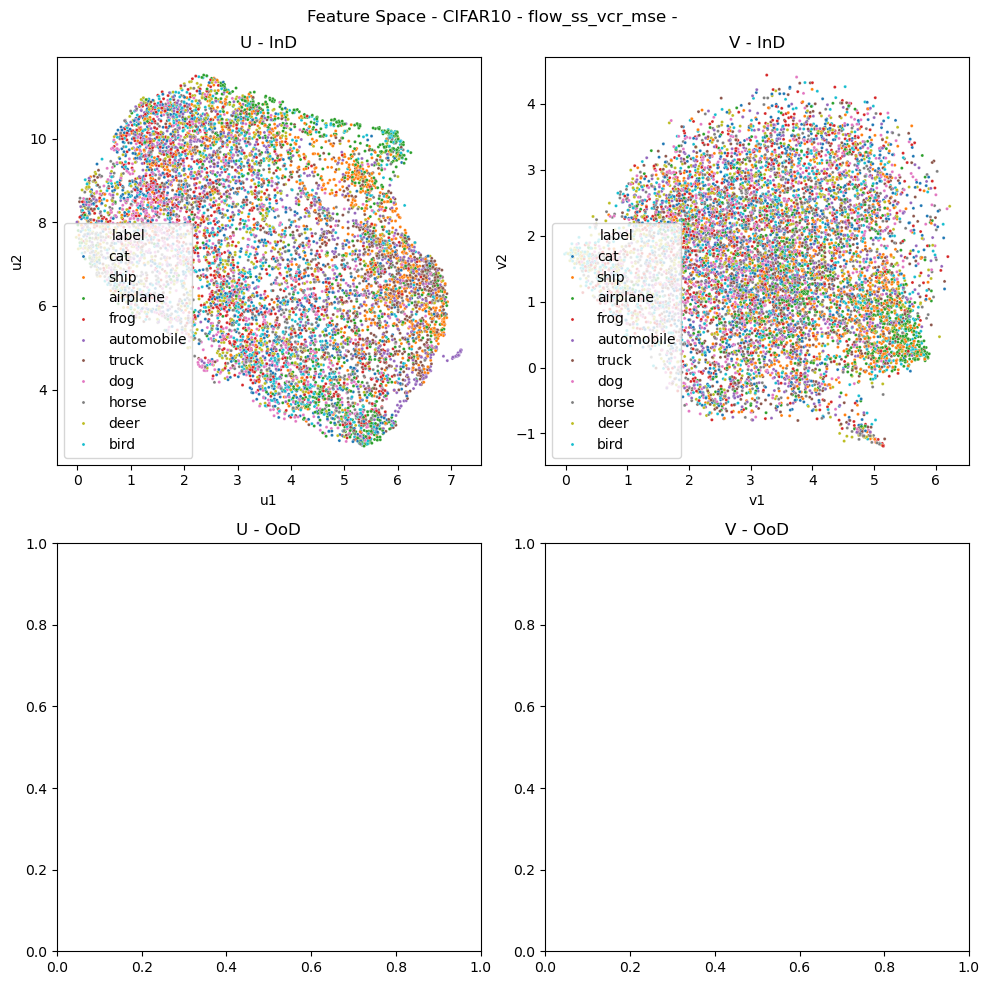

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

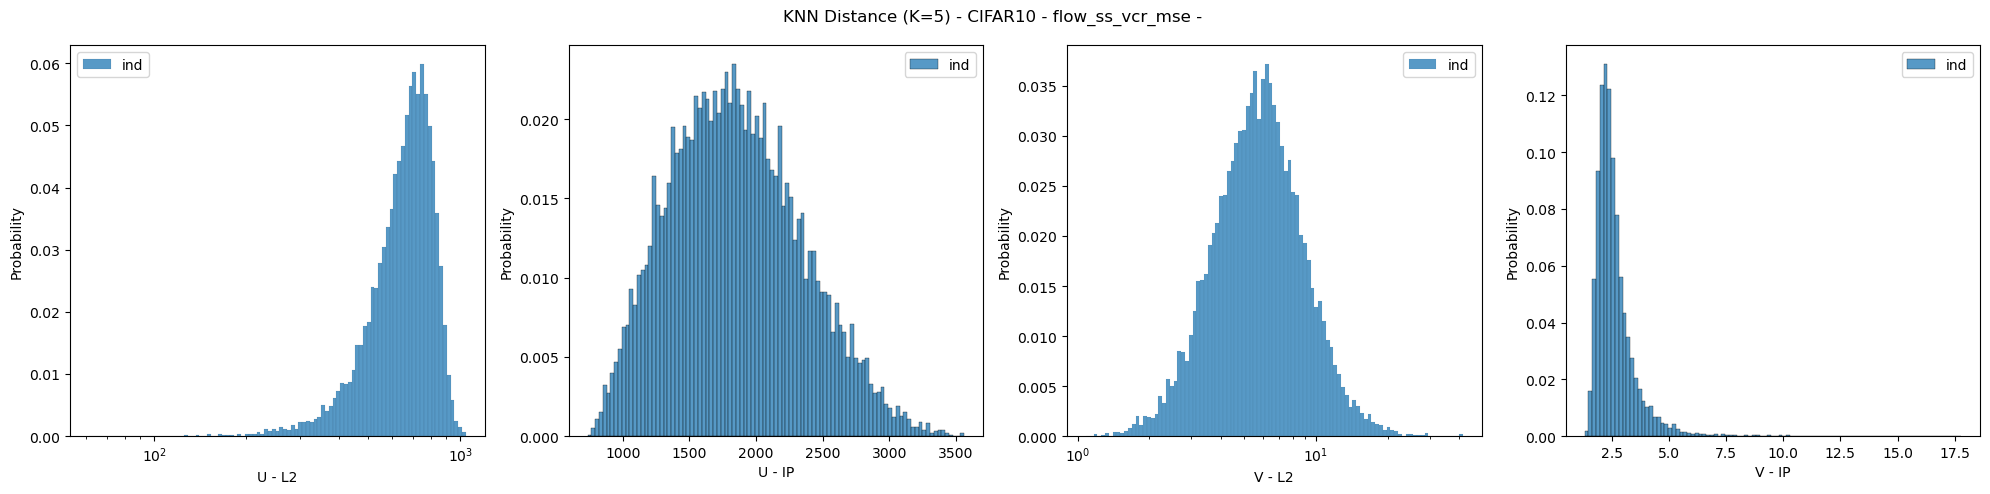

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

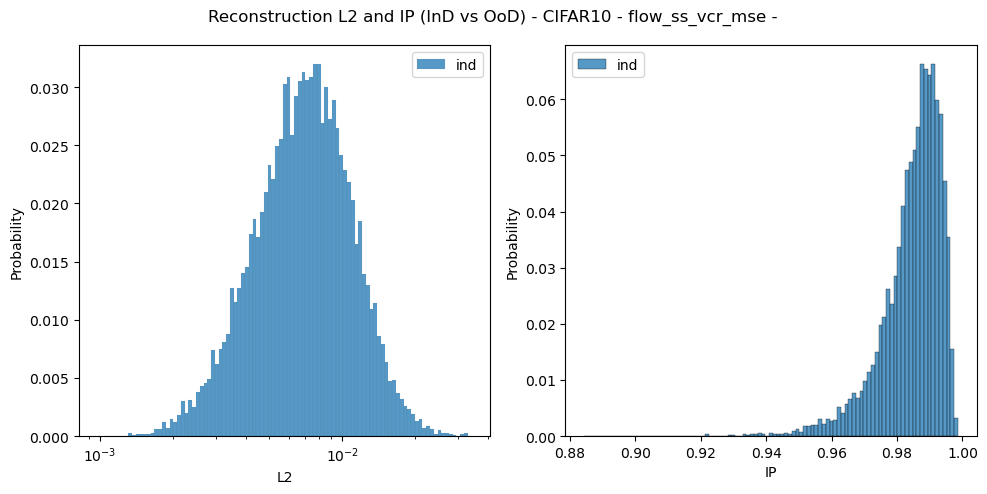

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

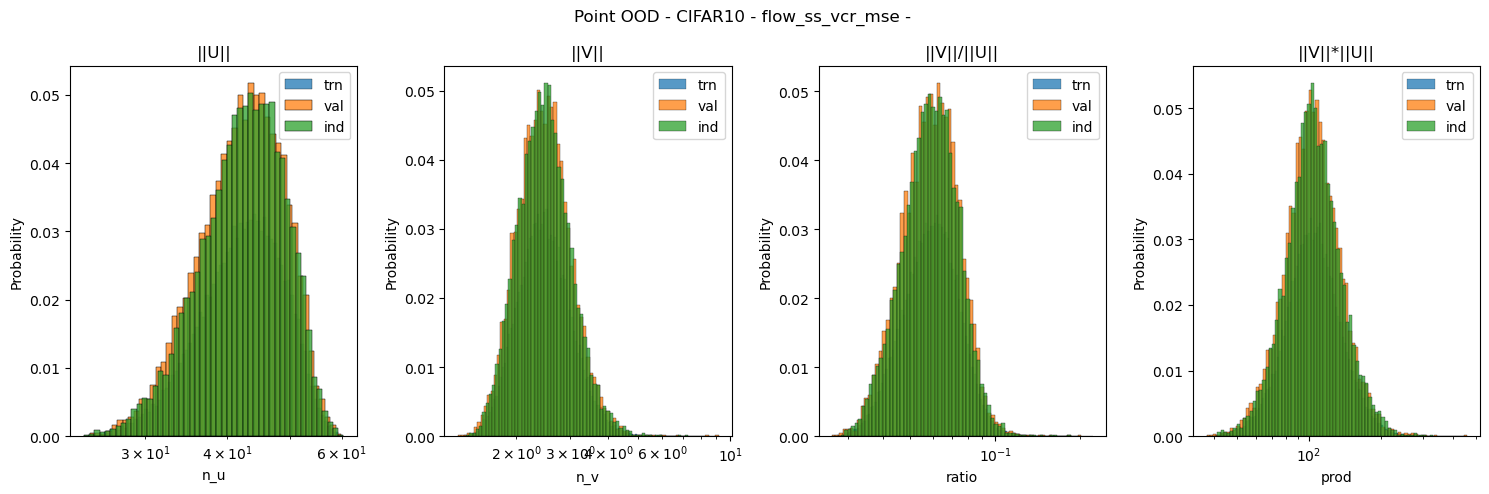

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


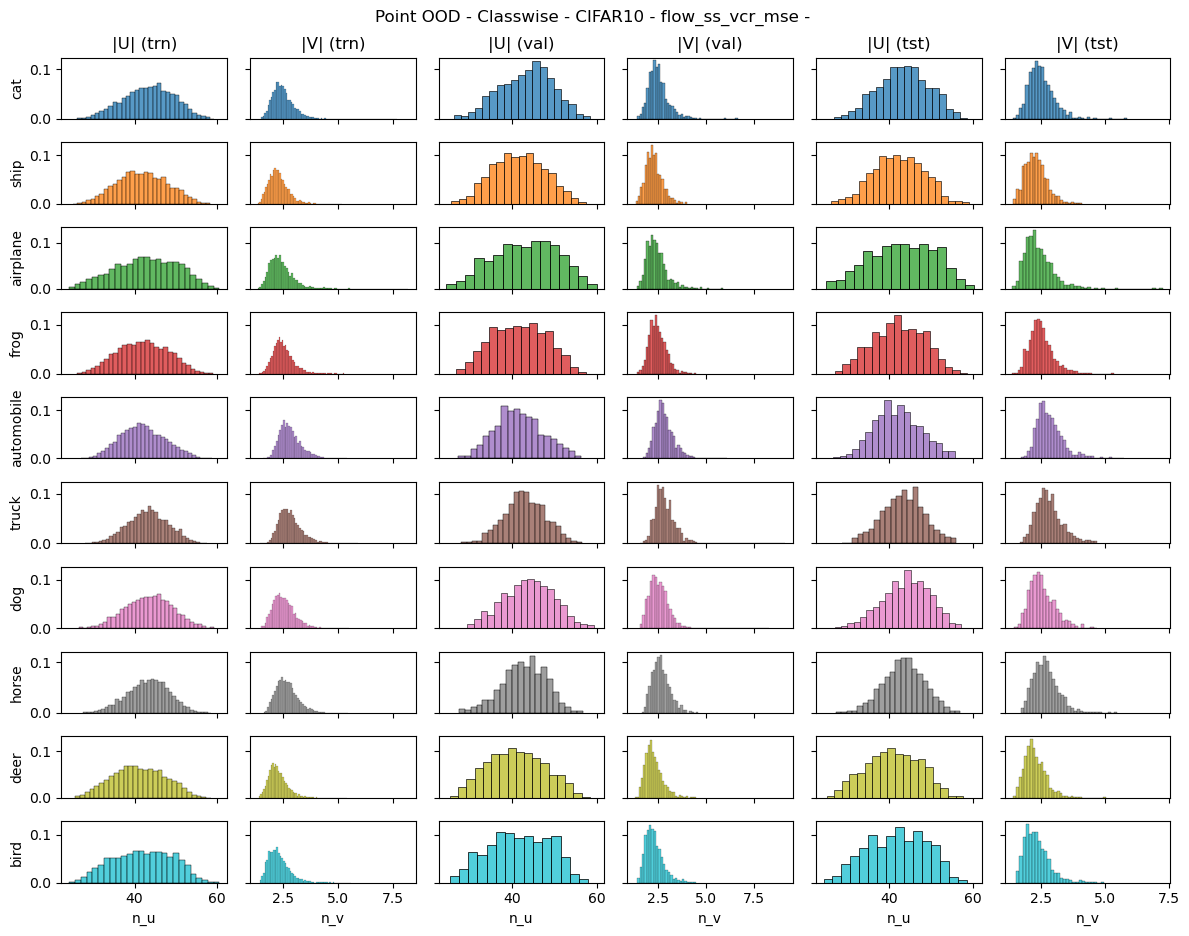

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

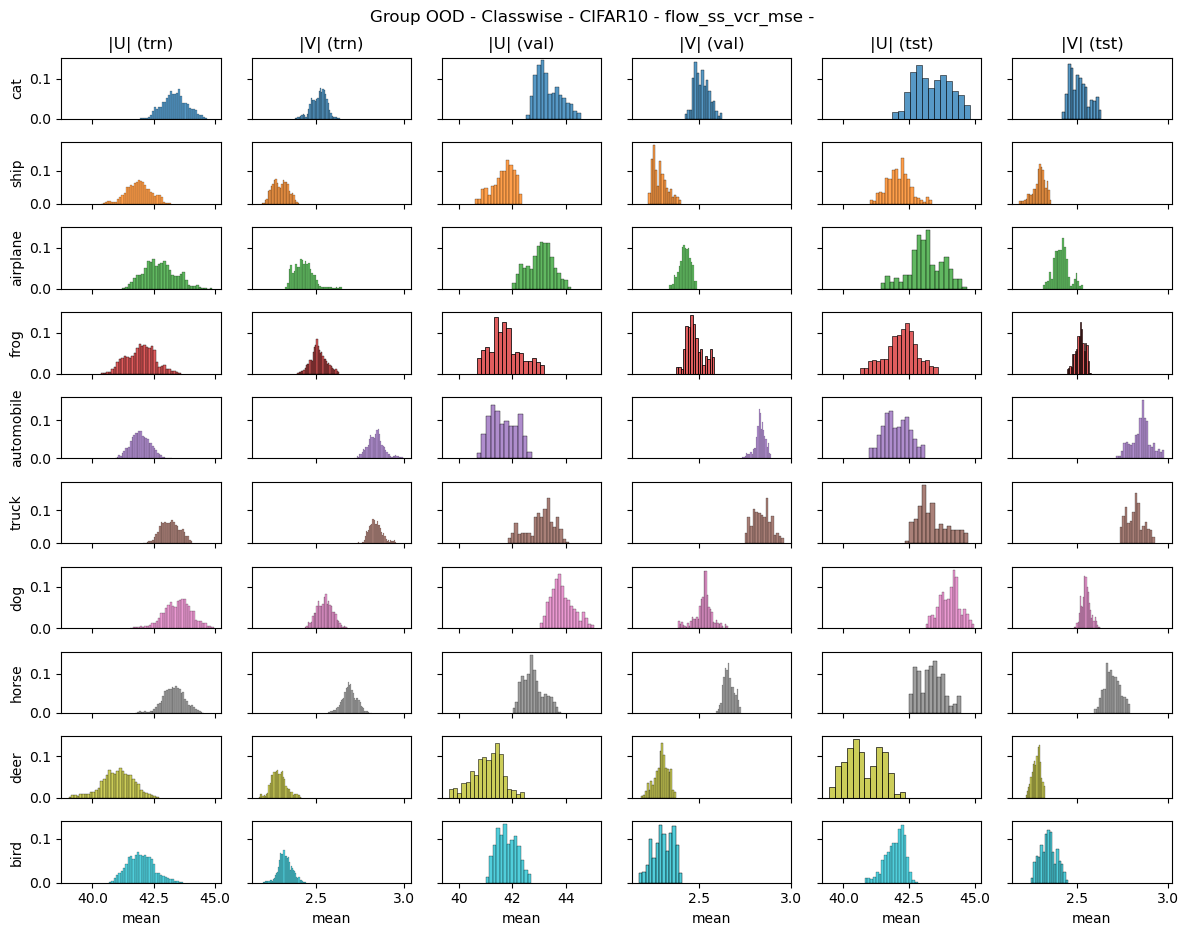

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)